In [2]:
from google.colab import drive
drive.mount("/content/gdrive")

Mounted at /content/gdrive


**Data Preprocessing**
> Kaggle fer2013 dataset

In [3]:
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
# Load data
df = pd.read_csv('/content/gdrive/My Drive/Data_For_Colab/IDS_705_Final_Project/fer2013.csv')

In [5]:
df.head()

,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


**Data Visualization**

In [6]:
# Test-Training Split 
X_train = df[df['Usage'] == 'Training']['pixels']
y_train = df[df['Usage'] == 'Training']['emotion']
X_val = df[df['Usage'] == 'PrivateTest']['pixels']
y_val = df[df['Usage'] == 'PrivateTest']['emotion']

In [7]:
math.sqrt(len(X_train[0].split(' ')))

48.0

In [8]:
#getting features for training
def reshape(data):
    X = []
    for xseq in data:
        xx = [int(xp) for xp in xseq.split(' ')]
        xx = np.asarray(xx).reshape(48, 48)
        X.append(xx.astype('float32'))
    X = np.asarray(X)
    X = np.expand_dims(X, -1)
    return X

X_train = reshape(X_train)
X_val = reshape(X_val)

In [37]:
emotion =['anger', 'disgust', 'fear', 'happiness', 'sadness', 'surprise', 'neutral']

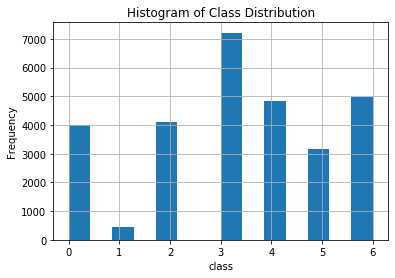

In [ ]:
pd.DataFrame(y_train).hist(bins=14)
plt.title('Histogram of Class Distribution')
plt.xlabel('class')
plt.ylabel('Frequency')
plt.show()

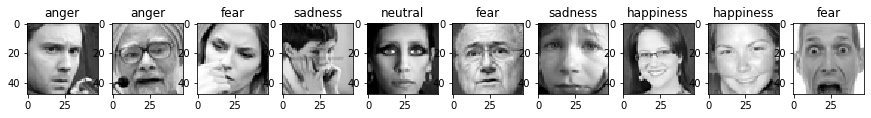

In [ ]:
plt.figure(figsize=(15,2))
X = df[df['Usage'] == 'Training']['pixels']
y = df[df['Usage'] == 'Training']['emotion']
X = X.apply(lambda x: np.array(x.split(' ')).astype('float32'))

for index, (image, label) in enumerate(zip(X[0:10], y[0:10])):
    plt.subplot(1, 10, index + 1)
    plt.imshow(np.reshape(image, (48,48)), cmap=plt.cm.gray)
    plt.title(emotion[y_train[index]])

In [9]:
y_train = pd.get_dummies(y_train).values.astype(np.float32)
y_val = pd.get_dummies(y_val).values.astype(np.float32)

In [10]:
y_train.shape

(28709, 7)

**Model**

In [11]:
# 10% of the training data
X_train_1 = X_train[:1000]
y_train_1 = y_train[:1000]
X_val_1 = X_val[:100]
y_val_1 = y_val[:100]

In [12]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.regularizers import l2

ResNet50

Model A

In [13]:
num_features = 64
num_labels = 7
batch_size = 64
epochs = 100
width, height = 48, 48

In [14]:
# Create the model
model = Sequential()

model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', input_shape=(width, height, 1), data_format='channels_last', kernel_regularizer=l2(0.01)))
model.add(Conv2D(num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(2*2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(2*2*2*num_features, kernel_size=(3, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())

model.add(Dense(2*2*2*num_features, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(2*2*num_features, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(2*num_features, activation='relu'))
model.add(Dropout(0.5))

model.add(Dense(num_labels, activation='softmax'))

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 46, 46, 64)        640       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 46, 46, 64)        36928     
_________________________________________________________________
batch_normalization (BatchNo (None, 46, 46, 64)        256       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 23, 23, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 23, 23, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 23, 23, 128)       73856     
_________________________________________________________________
batch_normalization_1 (Batch (None, 23, 23, 128)       5

In [16]:
# compile the model

model.compile(
    loss = 'categorical_crossentropy',
    optimizer = 'adam',
    metrics = ['accuracy']
)

In [17]:
# Train the model

#training the model
model.fit(np.array(X_train_1), np.array(y_train_1),
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data= (X_val, y_val))

Epoch 1/100
16/16 [==============================] - 109s 7s/step - loss: 4.5266 - accuracy: 0.1607 - val_loss: 9.7540 - val_accuracy: 0.1471
Epoch 2/100
16/16 [==============================] - 107s 7s/step - loss: 2.5523 - accuracy: 0.1721 - val_loss: 17.8602 - val_accuracy: 0.1627
Epoch 3/100
16/16 [==============================] - 111s 7s/step - loss: 2.2784 - accuracy: 0.1937 - val_loss: 4.5785 - val_accuracy: 0.1376
Epoch 4/100
16/16 [==============================] - 108s 7s/step - loss: 2.1773 - accuracy: 0.1574 - val_loss: 2.6058 - val_accuracy: 0.1716
Epoch 5/100
16/16 [==============================] - 106s 7s/step - loss: 2.0042 - accuracy: 0.1892 - val_loss: 3.4367 - val_accuracy: 0.2430
Epoch 6/100
16/16 [==============================] - 106s 7s/step - loss: 2.0524 - accuracy: 0.2101 - val_loss: 1.9972 - val_accuracy: 0.1655
Epoch 7/100
16/16 [==============================] - 106s 7s/step - loss: 1.9774 - accuracy: 0.1811 - val_loss: 1.9767 - val_accuracy: 0.1733
Epoch

In [20]:
#saving the model
model_yaml = model.to_yaml()
with open("modelA_1.yaml", "w") as yaml_file:
    yaml_file.write(model_yaml)
    
model.save("modelA_1 .h5")

In [22]:
from sklearn.metrics import classification_report, confusion_matrix
from matplotlib import pyplot

predictions = model.predict(X_val)
print(classification_report(np.argmax(y_val, axis=1), np.argmax(predictions, axis=1)))

              precision    recall  f1-score   support

           0       0.11      0.00      0.01       491
           1       0.00      0.00      0.00        55
           2       0.16      0.19      0.17       528
           3       0.41      0.24      0.30       879
           4       0.19      0.09      0.12       594
           5       0.31      0.65      0.42       416
           6       0.21      0.43      0.28       626

    accuracy                           0.25      3589
   macro avg       0.20      0.23      0.19      3589
weighted avg       0.24      0.25      0.22      3589



/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


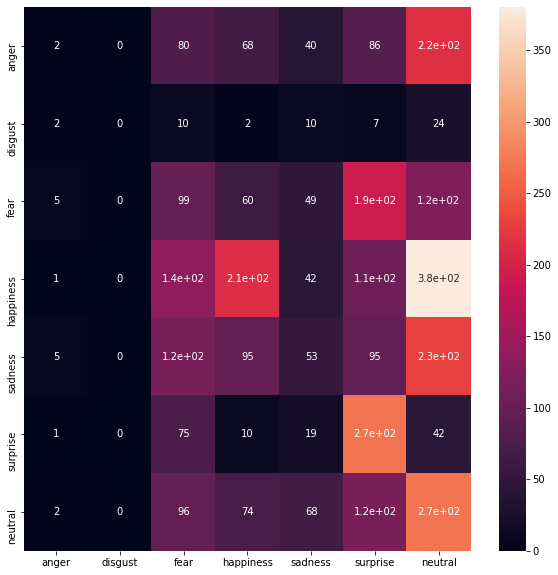

In [38]:
plt.figure(figsize = (10,10))
sns.heatmap(confusion_matrix(np.argmax(y_val, axis=1), np.argmax(predictions, axis=1)),
            xticklabels = emotion,
            yticklabels = emotion,
            annot = True
)
